In [1]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import datasets,decomposition,manifold
import sklearn.neighbors as nb
import scipy.io as sio
import struct
import pylab
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
#%pylab inline

In [2]:
def loadPGM(name):
    original_data_file = open(name,"rb")
    data_buff = original_data_file.read()
    data_index = 0
    s = struct.unpack_from('>14c',data_buff, data_index)
    data_index += struct.calcsize('>14c')
    m = struct.unpack_from('>10304B',data_buff, data_index)
    m = np.mat(m)
    return m

def PCM_show():
    data = loadPGM("orl_faces/s1/1.pgm")
    data = data.reshape(112, 92)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(data, cmap='gray')
    plt.show()


In [3]:
data=sio.loadmat("faces/ORL_32x32.mat")
face = data['fea']
label = data['gnd']

In [4]:
def NPE(data, k, d):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    data = np.matrix(data)
   
    N = data.shape[0]
    D = data.shape[1]
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    
    sort_index = np.argsort(distance,axis=1)

    # k nearest neibors
    neibors = sort_index[:,1:k+1]

    # step 2
    # weights
    W = np.zeros((N, N))
    
    # Gram Matrix
    if(k > D):
        add = 0.001
    else:
        add = 0
    for i in range(N):
        neibors_i = neibors[i].A[0]
        G = data[neibors_i[:]] - data[i] 
        G = np.dot(G, G.T)
        G = G + add * np.eye(k)*np.trace(G)
        G_I = G.I
        w_i = np.sum(G_I,axis=1) / np.sum(G_I)
        w_i = w_i.flatten([0])    
        W[i][neibors[i]]=w_i
    
    # Step 3
    # M 
    
    M=np.eye(N) - W
    M=np.dot(M.T, M)
    
   
    datatmp=data.T
    
    #SVD
    U, s, V = np.linalg.svd(datatmp)
    U = U[:, 0:np.linalg.matrix_rank(datatmp)]
    datatmp = np.dot(U.T, datatmp)
    
    
    # eig
    x1 = np.dot(datatmp, datatmp.T).I
    x2 = np.dot(np.dot(datatmp, M), datatmp.T)
    X = np.dot(x1, x2)
 
    eig_values, eig_vectors = np.linalg.eig(X)

    eig_index = np.argsort(eig_values)
    mapping = eig_vectors[:,eig_index[0:d]].T
    mapping = np.dot(mapping, U.T)
   
    return mapping

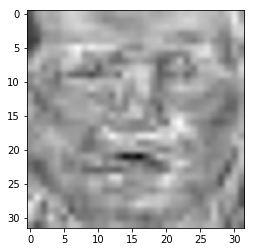

In [16]:
def NPE_faces():
    ## 112 * 92 ORL_faces
    allface=np.zeros((400, 10304))
    for i in range(40):
        for j in range(10):
            allface[i*10+j]=loadPGM("orl_faces/s"+str(i+1)+"/"+str(j+1)+".pgm")

    matfn = 'faces/2Train/3.mat'
    index = sio.loadmat(matfn)
    testIdx = index['testIdx'] -1    ### python 从0 开始
    trainIdx = index['trainIdx'] -1  ### python 从0 开始
    trainface = face[trainIdx]
    
    trainface = np.squeeze(trainface) 
    
    
    mapping = NPE(trainface/255, 20, 8)
    tmp=mapping[4]
    tmp=tmp.reshape(32, 32).astype(float)
    pylab.imshow(tmp.T, cmap='gray', interpolation='hamming')
    pylab.show()
NPE_faces()

In [12]:
def knn_score(train_data, train_label, test_data, test_label):
    knn = nb.KNeighborsClassifier(n_neighbors = 1)  
    knn.fit(train_data, train_label)
    s = knn.score(test_data, test_label)
    return s

In [7]:
def baseline(l):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(50):
        matfn = 'faces/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = sio.loadmat(matfn)
        testIdx = index['testIdx'] -1    ### python 从0 开始
        trainIdx = index['trainIdx'] -1  ### python 从0 开始
        trainface = face[trainIdx]
        trainlabel = label[trainIdx].reshape(l*40,1)
        trainface = np.squeeze(trainface) 
        testface = face[testIdx]
        testlabel = label[testIdx].reshape(400-l*40,1)
        testface = np.squeeze(testface)  
        
        s+=knn_score(trainface, trainlabel, testface, testlabel)
    return s/50

basescore=baseline(5)
print(basescore)

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8809


In [6]:
def NPEscore(l,d):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(50):
        matfn = 'faces/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = sio.loadmat(matfn)
        testIdx = index['testIdx'] -1    ### python 从0 开始
        trainIdx = index['trainIdx'] -1  ### python 从0 开始
        trainface = face[trainIdx]
        trainlabel = label[trainIdx].reshape(l*40,1)
        trainface = np.squeeze(trainface) 
        
        testface = face[testIdx]
        testlabel = label[testIdx].reshape(400-l*40,1)
        testface = np.squeeze(testface)  
       
        mapping = NPE(trainface/255, 50, d)
        
        traindata = np.dot(mapping, trainface.T)
        testdata = np.dot(mapping, testface.T)
        s+=knn_score(traindata.T, trainlabel, testdata.T, testlabel)
    return s/50
for i in range(2,10,2):
    print("dim",i)
    NPE_score = NPEscore(4,i)
    print(NPE_score)

dim 2


/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.056
dim 4
0.207333333333
dim 6
0.407166666667
dim 8
0.53675


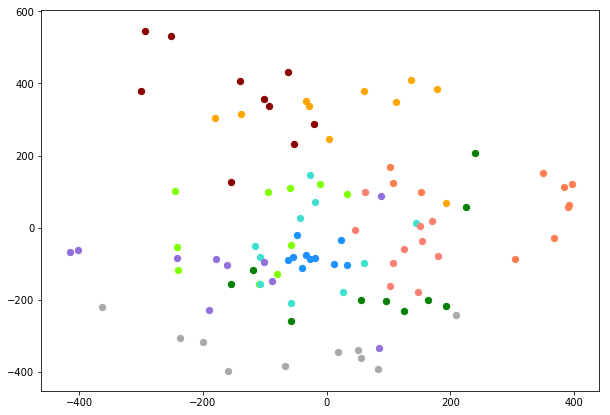

In [12]:
def orl_scatters():
    # the first 100 samples
    face100 = np.squeeze(face)[:100]
    label100 = label.reshape(400)[:100]
    mapping = NPE(face100/255, 50, 3)
    
    low_data = np.dot(mapping[1:3], face100.T).T
 
    fig = plt.figure(figsize=(10,7))
    plotwindow = fig.add_subplot(111)
    a = np.array(low_data)

    # draw the scatters
    color = ['green','dodgerblue','chartreuse','turquoise','orange','coral','salmon','darkgray','darkred','mediumpurple']
    for j in range(len(low_data)):
        plt.scatter(a[j][0], a[j][1],s=40, c=color[label100[j]-1])
    plt.show()
orl_scatters();